# 平均に隠れた本音を暴く。混合モデルによる顧客満足度構造の深堀り
「満足度 3.5 点」という平均値の裏側には、「熱狂的なファン」と「静かな不満層」が混在している可能性がある。この「声なき多層構造」をベイズの千里眼で可視化し、商品・サービス改善の真の優先順位を特定する。

## ユースケース
新商品発売やリニューアル後、アンケート結果が「中途半端な平均値」に落ち着いてしまい、次の一手に迷っている。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pymc as pm
import arviz as az

warnings.filterwarnings("ignore")

/home/peta/petaLab/bayesian-iroha/.venv/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
# Color Identity
COLOR_PURPLE = "#985DE5"
COLOR_BLUE   = "#118AB2"
COLOR_GREEN  = "#06D6A0"
COLOR_YELLOW = "#F9C74F"
COLOR_RED    = "#EF476F"
COLOR_GRAY   = "#8D99AE"

plt.rcdefaults()  # plt の現在のカラー定義をリセット
palette_brand = [COLOR_PURPLE, COLOR_BLUE, COLOR_GREEN, COLOR_YELLOW, COLOR_RED, COLOR_GRAY]

sns.set_theme(style="whitegrid", palette=palette_brand)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_brand)

In [3]:
# 可視化時に日本語を表示可能にする
import japanize_matplotlib

plt.rcParams["font.family"] = "IPAexGothic"

In [4]:
# n=30 の満足度データを生成（熱狂層: 0.6, 失望層: 0.4）
np.random.seed(42)

n_obs = 30
idx_group = np.random.choice([0, 1], size=n_obs, p=[0.6, 0.4])
mu_true = [4.5, 1.8]
sigma_true = [0.3, 0.5]

observation_satisfaction = np.random.normal(loc=np.array(mu_true)[idx_group], scale=np.array(sigma_true)[idx_group])
observation_satisfaction = np.clip(observation_satisfaction, 1.0, 5.0)

In [5]:
observation_satisfaction.mean()  # 観測データの平均を出力

np.float64(3.600766062133175)

## ビジネス課題の定義
### 課題
- 「平均 3.6 点」という数字では、改善すべき点が「全員にとってのあと一歩」なのか、「一部の深刻な不満」なのか判別できない。
- 全員の平均を取ることで、熱狂的なファンの尖った評価が埋もれ、凡庸な施策に陥るリスクがある。

### 解決したい「問い」
- 満足度データの中に、異なる評価軸を持つ「隠れたグループ」はいくつ存在するか？
- 各グループの構成比率と、それぞれの平均的な満足度はどの程度か？

## EDA (Exploratory Data Analysis)
記述統計量に頼らず、ヒストグラムでデータのモダリティ（山の数）を把握する。

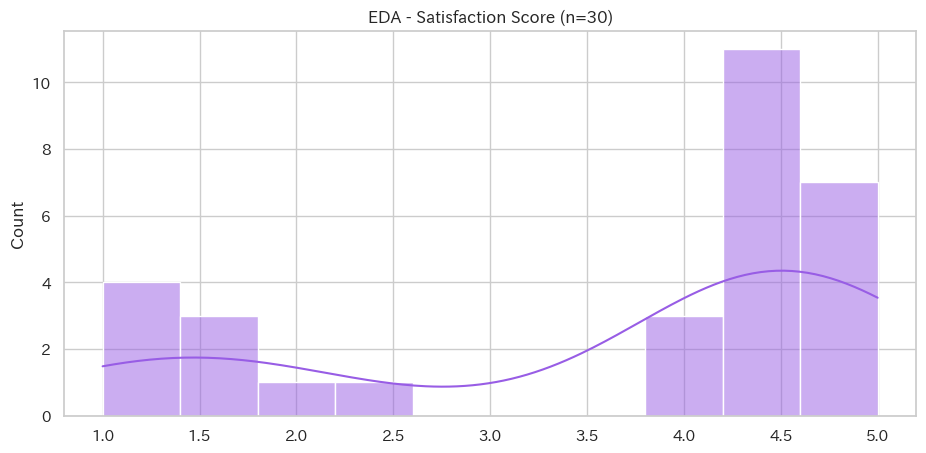

In [6]:
# ヒストグラムで分布を確認
plt.figure(figsize=(11, 5))
sns.histplot(observation_satisfaction, bins=10, kde=True)
plt.title(f"EDA - Satisfaction Score (n={n_obs})")
plt.show()

単一の正規分布では説明しきれない「二峰性」があることを確認。

## 戦略的問い立て（OS の選択）
観測データ: $D$ が単一の確率分布から生成されたと見なさず、複数の潜在的なサブグループ（コンポーネント） $k$ の重ね合わせとしてモデル化する。
>数式: 全体の分布 $f(x)$ を各グループの比率 $w_k$ と分布 $f_k$ の積の総和として表現
>
>$f(x) = \sum_{k=1}^{k} w_k f_k(x|\theta_k)$
>
> 全体の確率密度関数 $f(x)$ を、$K$ 個の異なる集団（コンポーネント）の比率（重み） $w_k$ と、それぞれの集団が持つ固有の分布 $f_k$ （パラメータ $\theta_k$ によって決定される）の加重平均として記述するモデル。


### OS (エンジン)
階層ベイズの考え方を応用した混合モデル

#### 選定根拠
1. 個性と共通性の共存 (階層性の応用)
    階層ベイズは「個別のデータの違い」を認めつつ、「全体としての共通性」も加味する手法です。混合モデルはこの考え方を応用し、「顧客一人ひとりは違うが、大きく分ければ数種類のタイプ（セグメント）に集約される」という仮説を構造化する。
    これにより、「個別のバラツキ」に惑わされず、「集団としての傾向」を安定して抽出可能に。
2. 小規模データにおける「確信」の担保
    今回の $n=30$ というデータ量は、一般的な統計手法では「有意差なし」や「過学習」のリスクが高い領域。
    - **事前知識の活用**: 「顧客には満足層と不満層がいるはずだ」という業界知見を事前分布として組み込むことで、少ないデータからでも効率的に構造を表現。
    - **不確実性の可視化** : 抽出されたセグメント比率 $w$ や平均値 $\mu$ を「点」ではなく「分布(幅)」として算出するため、経営者は「最悪のシナリオ」を想定した意思決定が可能に。
3. 意思決定プロセス「期待効用」への直結
    混合モデルを選ぶ最大のビジネス的メリットは、「どのグループをターゲットにすべきか」が確率的に計算可能になる点。
    - 単一の平均値モデルでは「全員に対して一律の施策」しか提案できません。
    - 混合モデル (OS)であれば、「40%の失望層を救う施策」と「60%の熱狂層を維持する施策」のそれぞれの投資対効果（期待効用） を天秤にかけることができる。

## ベジパタ OS 選定

カテゴリ | 問い立て(戦略的意図) | OS(エンジン) | デザインパターン | 意思決定プロセス | 推奨プロット
--- | --- | --- | --- | --- | ---
深堀 | 平均に隠れた特殊な集団はないか？ | 混合モデル | ⑬サイレント・マジョリティ | 期待効果(セグメント) | クラスター密度図

## 分析用データ加工
PyMC での計算結果にビジネス上のラベル（失望層・熱狂層）を紐づける準備をする。

In [7]:
# PyMC用の座標 (coords) と次元 (dims) の設定
coords = {
    "id_obs": np.arange(n_obs),
    "cluster": ["Disappointed", "Enthusiast"]
}

## 確率モデルの構築
データの背後にある「生成プロセス」を数理モデルとして定義します。<br>
複数の正規分布を比率で混ぜ合わせた確率分布です。

In [8]:
with pm.Model(coords=coords) as model_mixture:
    # 構成比率 (w) の事前分布
    # ２つのセグメント(失望層・熱狂層）の比率を推定
    # a=[1, 1] は「どの比率も等しくあり得る（無情報）」という設定
    w_cluster = pm.Dirichlet("cluster_w", a=np.array([1, 1]), dims="cluster")

    # 平均 (mu) の事前分布: ラベルスイッチングを防ぐため初期値を分ける
    mu_cluster = pm.Normal("mu_cluster", mu=[2, 4], sigma=1, dims="cluster")
    sigma_cluster = pm.HalfNormal("sigma_cluster", sigma=1, dims="cluster")

    observation = pm.NormalMixture("observation", w=w_cluster, mu=mu_cluster,
                                   sigma=sigma_cluster, observed=observation_satisfaction,
                                   dims="id_obs")


## 事前予測チェック (Prior Predictive Check)
「２つのグループがある」という仮説が、現実的な範囲のデータを生成するか確認します。<br>
自分たちの作った数式モデルで、まともなデータが生成されるかテストします。

In [9]:
with model_mixture:
    # 事前予測サンプリング
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [cluster_w, mu_cluster, observation, sigma_cluster]


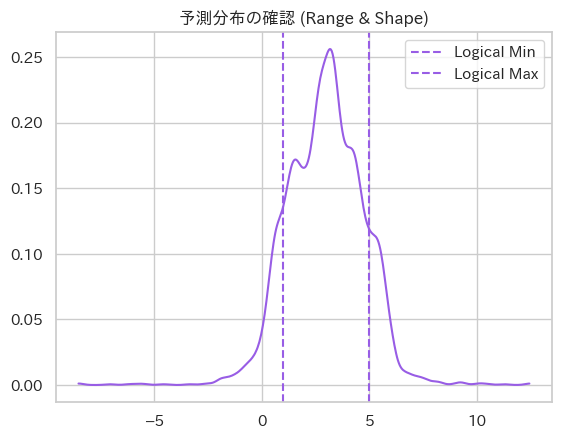

In [10]:
# 物理&論理的な「範囲」の確認
observation_samples_prior = idata_prior.prior_predictive["observation"]
az.plot_dist(observation_samples_prior)
plt.axvline(1.0, linestyle="--", label="Logical Min")
plt.axvline(5.0, linestyle="--", label="Logical Max")
plt.title("予測分布の確認 (Range & Shape)")
plt.legend()
plt.show()

### 事前予測分布の解釈
分布が -4 から 10 付近まで広がっている。
1. 満足度調査では「-2点」や「8点」という回答は、現実には存在しない
2. モデルが「-4点もあり得る」と想定した状態でサンプリングを開始すると、実際のデータを説明するのに時間がかかったり、収束が不安定になる原因になる。

In [11]:
# チューニング
with pm.Model(coords=coords) as model_mixture_v1:
    # 構成比率 (w) の事前分布
    # ２つのセグメント(失望層・熱狂層）の比率を推定
    # a=[1, 1] は「どの比率も等しくあり得る（無情報）」という設定
    w_cluster = pm.Dirichlet("cluster_w", a=np.array([1, 1]), dims="cluster")

    # 平均 (mu) の事前分布: ラベルスイッチングを防ぐため初期値を分ける
    mu_cluster = pm.Normal("mu_cluster", mu=[2, 4], sigma=0.5, dims="cluster")
    sigma_cluster = pm.HalfNormal("sigma_cluster", sigma=0.5, dims="cluster")

    observation = pm.NormalMixture("observation", w=w_cluster, mu=mu_cluster,
                                   sigma=sigma_cluster, observed=observation_satisfaction,
                                   dims="id_obs")

    idata_prior_v1 = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [cluster_w, mu_cluster, observation, sigma_cluster]


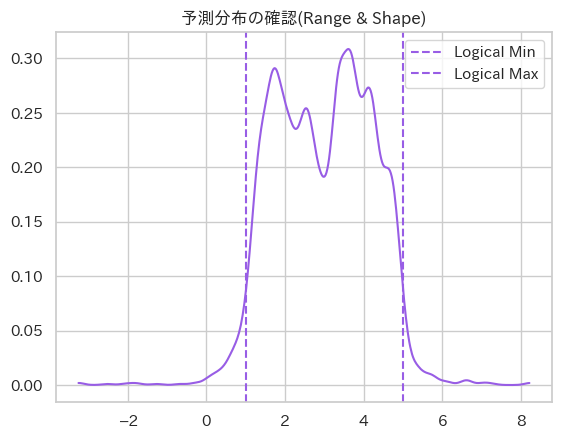

In [12]:
observation_samples_prior_v1 = idata_prior_v1.prior_predictive["observation"]
az.plot_dist(observation_samples_prior_v1)
plt.axvline(1.0, linestyle="--", label="Logical Min")
plt.axvline(5.0, linestyle="--", label="Logical Max")
plt.title("予測分布の確認(Range & Shape)")
plt.legend()
plt.show()

`sigma=0.5` によって分布の大部分が 1.0 ~ 5.0 の枠内に収まってきているが物理・理論的に発生しない範囲外の回答が発生する可能性があります。

これ以上 sigma を絞ると、「各グループ内にはある程度の多様性（バラツキ）がある」という仮説まで否定することになり、モデルが窮屈になりすぎてしまいます。
正規分布を使っている以上、数学的に「裾（テール）」が無限に続くのは避けられません。

そこで、「無理に山を細くする」のではなく現在の 正規分布 (Normal) を、範囲外を物理的に許さない 截断正規分布 (Truncated Normal) に差し替えます。
>截断正規分布 (Truncated Normal Distribution)
>通常の正規分布 $N(\mu, \sigma^2)$ の確率密度関数に対し、指定した範囲 $[a, b]$ 外の確率を 0 とし、範囲内の面積が 1 になるよう再正規化した分布。
$f(x|\mu, \sigma, a, b) = \frac{\phi(\frac{x-\mu}{\sigma})}{\sigma(\Phi(\frac{b-\mu}{\sigma}) - \Phi(\frac{a-\mu}{\sigma}))} \quad (a \le x \le b)$

In [19]:
with pm.Model(coords=coords) as model_mixture_v2:
    # 比率の事前分布
    w_cluster = pm.Dirichlet("cluster_w", a=np.array([1, 1]), dims="cluster")

    # 平均と標準偏差
    # mu を [1, 5] に截断して安全に
    mu_cluster = pm.TruncatedNormal("mu_cluster", mu=[2, 4], sigma=0.5, lower=1, upper=5, dims="cluster")
    # sigma が 1.0 を超えるとグループ内のばらつきが極端になりすぎる
    sigma_cluster = pm.TruncatedNormal("sigma_cluster", mu=0, sigma=0.5, lower=0.05, upper=1.5, dims="cluster")

    # mu[0] < mu[1] を強制 -> ラベルスイッチングを構造的に防止
    pm.Potential("order_constraint", pm.math.switch(mu_cluster[0] < mu_cluster[1], 0, -np.inf))

    # 截断正規分布をコンポーネントとして定義
    dist_component = pm.TruncatedNormal.dist(mu=mu_cluster, sigma=sigma_cluster, lower=1, upper=5, shape=2)

    # 混合モデルの定義
    observation = pm.Mixture("observation", w=w_cluster, comp_dists=dist_component, observed=observation_satisfaction,
                             dims="id_obs")

- `mu` 自体も裁断
    mu_cluster ~ Normal(mu=[2, 4], sigma=0.5) は無截断なので、理論上 mu が 0 や 6 を取る確率がゼロではありません。
    截断正規分布の mu パラメータが定義域外に出ると、コンポーネントの確率密度が極端に歪み、サンプラーの効率が下がるリスクがあります。

- `sigma` のスケール感を明示する
    HalfNormal(sigma=0.5) は 95% が約 0〜1.0 に収まりますが、sigma > 1.5 といった値も稀に生成されます。
    1〜5 の 4 点幅のスケールでは sigma=1.5 は「ほぼ一様分布」に近く、グループの意味が薄れます。

- ラベルスイッチングを構造的に防止する
    事前平均 [2, 4] で「大体は分かれる」のですが、MCMC チェインが長い場合にスイッチする可能性はゼロではありません。
    明示的な順序制約を入れると安心です。


In [20]:
# 事前予測サンプリング
with model_mixture_v2:
    idata_prior_v2 = pm.sample_prior_predictive(samples=500, random_seed=42)

Sampling: [cluster_w, mu_cluster, observation, sigma_cluster]


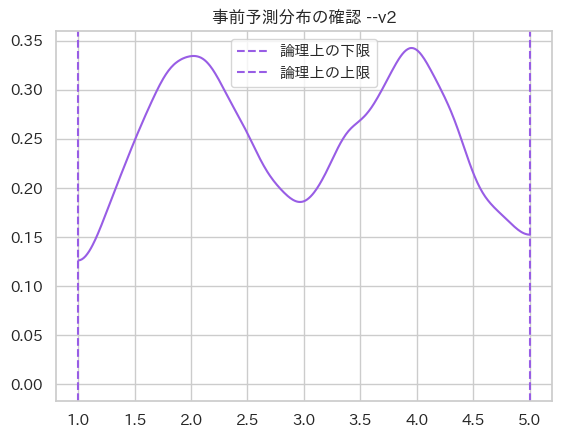

In [21]:
observation_samples_prior_v2 = idata_prior_v2.prior_predictive["observation"]
az.plot_dist(observation_samples_prior_v2)
plt.axvline(1.0, linestyle="--", label="論理上の下限")
plt.axvline(5.0, linestyle="--", label="論理上の上限")
plt.title("事前予測分布の確認 --v2")
plt.legend()
plt.show()

以下の３点が達成されました。
1. 境界の厳格性: 1.0 未満、5.0 超のサンプルが物理的に存在せず、ビジネス上の矛盾が解消されています。
2. 二峰性の維持: 2.0 付近と 4.0 付近に明確なピークがあり、「サイレント・マジョリティ」を分離する準備が整っています。
3. 確信の「幅」: 山の裾野が広すぎず、かつ平坦すぎないため、実際のデータ（$n=30$）が持つ情報を吸収するのに最適な「柔軟な予習」になっています。